# Stock Price Prediction

### [2024.02.05] 이상혁

### 개요
- [출처] 딥러닝 파이토치 교과서 7장 5절의 LSTM
- 어떤 기업의 주가 데이터를 사용해서 모델이 주가 예측을 잘 하는지 알아보자.
- 사용하는 데이터는 야후에서 제공하는 스타벅스의 주가이다.

### 0. GPU Configuration

💻빠른 연산을 위해 Tensorflow에서 **GPU**를 사용할 수 있도록 설정해준다.

In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# 시드 고정
torch.manual_seed(205)

if device == 'cuda':
    torch.cuda.manual_seed_all(205)

GPU 설정과 시드 설정을 모두 완료했다.

### 1. Libraries

In [24]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import time
import random
import datetime

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [4]:
os.chdir('C:\Python_Programs\Pytorch/2. Stock Price')

- 작업 디렉토리도 추가해줬다.

### 2. Load Data

데이터는 야후 주가에서 csv로 다운 받을 수도 있다. 여기서는 책에서 제공하는 데이터를 사용했다.

In [5]:
data = pd.read_csv('SBUX.csv', encoding='utf-8-sig')

### 3. EDA & Pre-processing

In [6]:
# 데이터 확인
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-11,86.260002,86.870003,85.849998,86.589996,84.145752,4921900
1,2019-12-12,88.000000,88.889999,87.540001,88.209999,85.720032,10282100
2,2019-12-13,88.019997,88.790001,87.580002,88.669998,86.167046,6714100
3,2019-12-16,89.139999,89.300003,88.430000,88.779999,86.273941,6705600
4,2019-12-17,88.870003,88.970001,87.470001,88.129997,85.642288,7296900


In [7]:
# 데이터 타입 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       253 non-null    object 
 1   Open       253 non-null    float64
 2   High       253 non-null    float64
 3   Low        253 non-null    float64
 4   Close      253 non-null    float64
 5   Adj Close  253 non-null    float64
 6   Volume     253 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 14.0+ KB


- Date라는 열은 별도 정보를 갖고 있지 않기 때문에 인덱스로 사용하면 좋다.
- 추후 텐서로 변경할 때 통일성을 위해 Volume 열도 실수로 만들어준다.

In [8]:
# 'date' 열 생성 후 인덱스 화
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# 확인
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,84.145752,4921900
2019-12-12,88.000000,88.889999,87.540001,88.209999,85.720032,10282100
2019-12-13,88.019997,88.790001,87.580002,88.669998,86.167046,6714100
2019-12-16,89.139999,89.300003,88.430000,88.779999,86.273941,6705600
2019-12-17,88.870003,88.970001,87.470001,88.129997,85.642288,7296900


In [9]:
# 실수화
data['Volume'] = data['Volume'].astype('float64')

# 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2019-12-11 to 2020-12-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       253 non-null    float64
 1   High       253 non-null    float64
 2   Low        253 non-null    float64
 3   Close      253 non-null    float64
 4   Adj Close  253 non-null    float64
 5   Volume     253 non-null    float64
dtypes: float64(6)
memory usage: 13.8 KB


어느 정도 전처리가 완료되었다. X와 y(라벨)로 분리하자. 

In [10]:
# 데이터와 레이블 분리
X = data.iloc[:, :-1]
y = data['Volume'].to_frame()

# 데이터 확인
X.head()

,Open,High,Low,Close,Adj Close
Date,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,84.145752
2019-12-12,88.000000,88.889999,87.540001,88.209999,85.720032
2019-12-13,88.019997,88.790001,87.580002,88.669998,86.167046
2019-12-16,89.139999,89.300003,88.430000,88.779999,86.273941
2019-12-17,88.870003,88.970001,87.470001,88.129997,85.642288


In [11]:
y.head()

,Volume
Date,
2019-12-11,4921900.0
2019-12-12,10282100.0
2019-12-13,6714100.0
2019-12-16,6705600.0
2019-12-17,7296900.0


이번에는 데이터의 기초 통계량을 확인해보자. 만약 축이 너무 다르다면 스케일링이 필요할 것이다.

In [12]:
# 데이터 통계량 확인
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,253.000000,253.000000,253.000000,253.000000,253.000000,2.530000e+02
mean,81.977273,82.973043,80.871462,81.998656,80.479205,9.687298e+06
std,9.228221,8.946584,9.678252,9.272335,9.288642,5.131906e+06
min,55.549999,57.439999,50.020000,56.330002,54.995056,1.847800e+06
25%,75.370003,76.370003,74.430000,75.440002,74.068405,6.197700e+06
50%,82.599998,83.239998,81.750000,82.410004,81.351830,8.238600e+06
75%,88.500000,89.110001,87.720001,88.510002,86.475174,1.137890e+07
max,103.510002,106.089996,102.750000,105.389999,104.527336,2.877060e+07


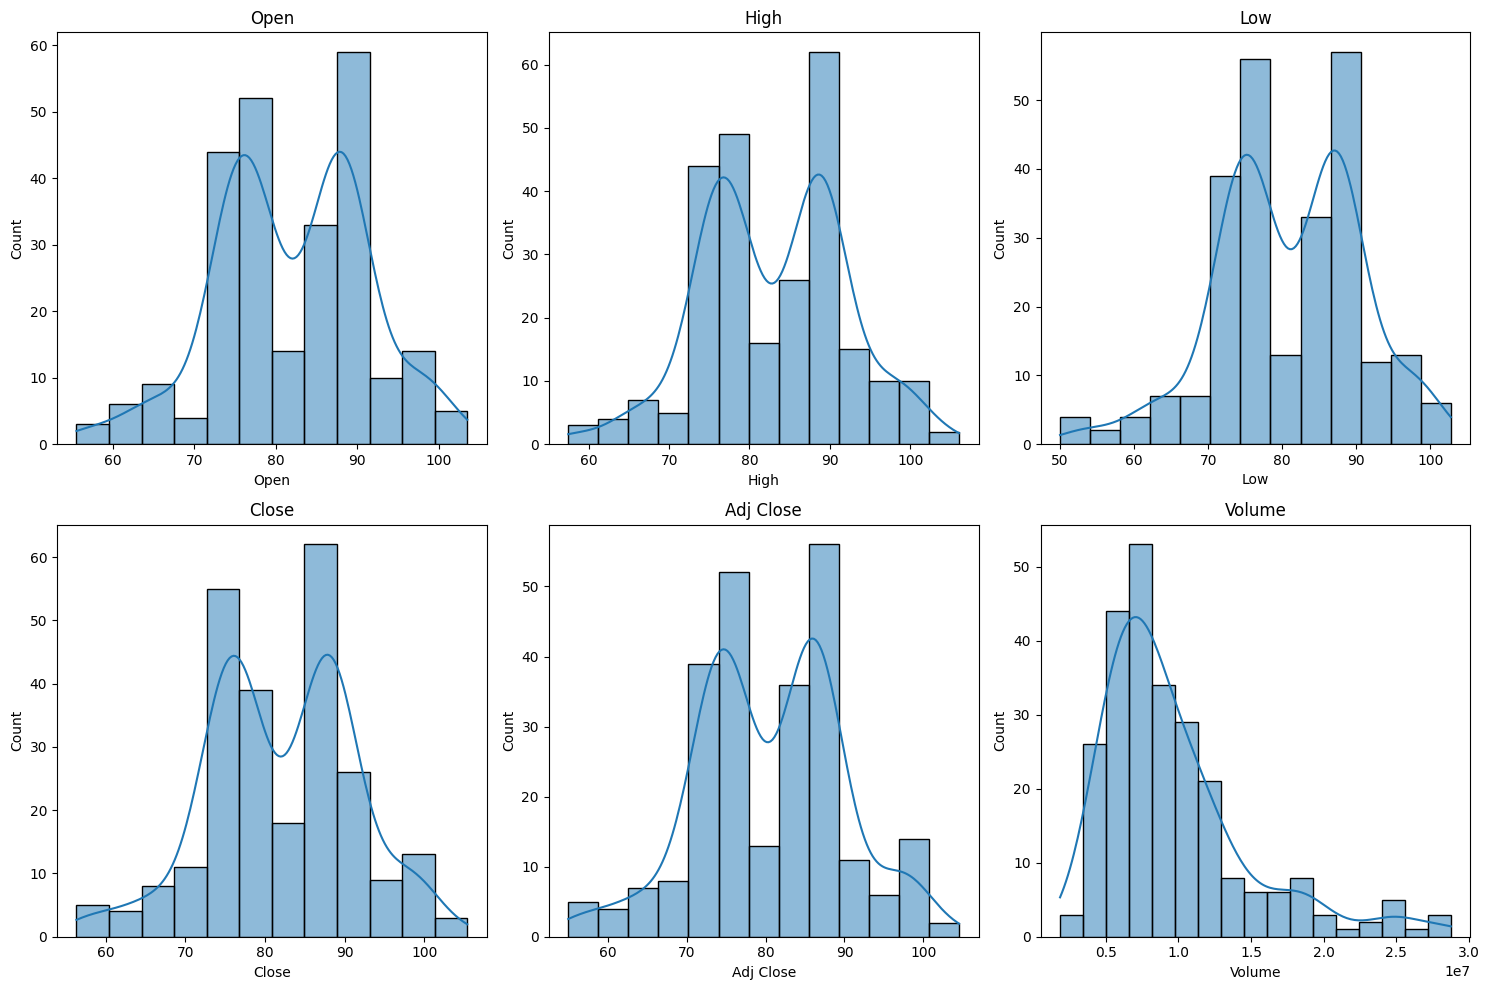

In [13]:
# subplot 틀 구성
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# 변수 이름 가져오기
variables = data.columns

# 각 변수에 대해서 subplot 그리기
for i, var in enumerate(variables):
    sns.histplot(data[var], kde=True, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(var)

# subplot 간격 조절
plt.tight_layout()

# 그래프 보여주기
plt.show()

- 스케일링을 적용해서 데이터 간의 분포를 유사하게 만들어주자.

In [14]:
# MinMax, Standard 스케일링
minmax = MinMaxScaler()
standard = StandardScaler()

# 변환
X_scaled = standard.fit_transform(X)
y_scaled = minmax.fit_transform(y)

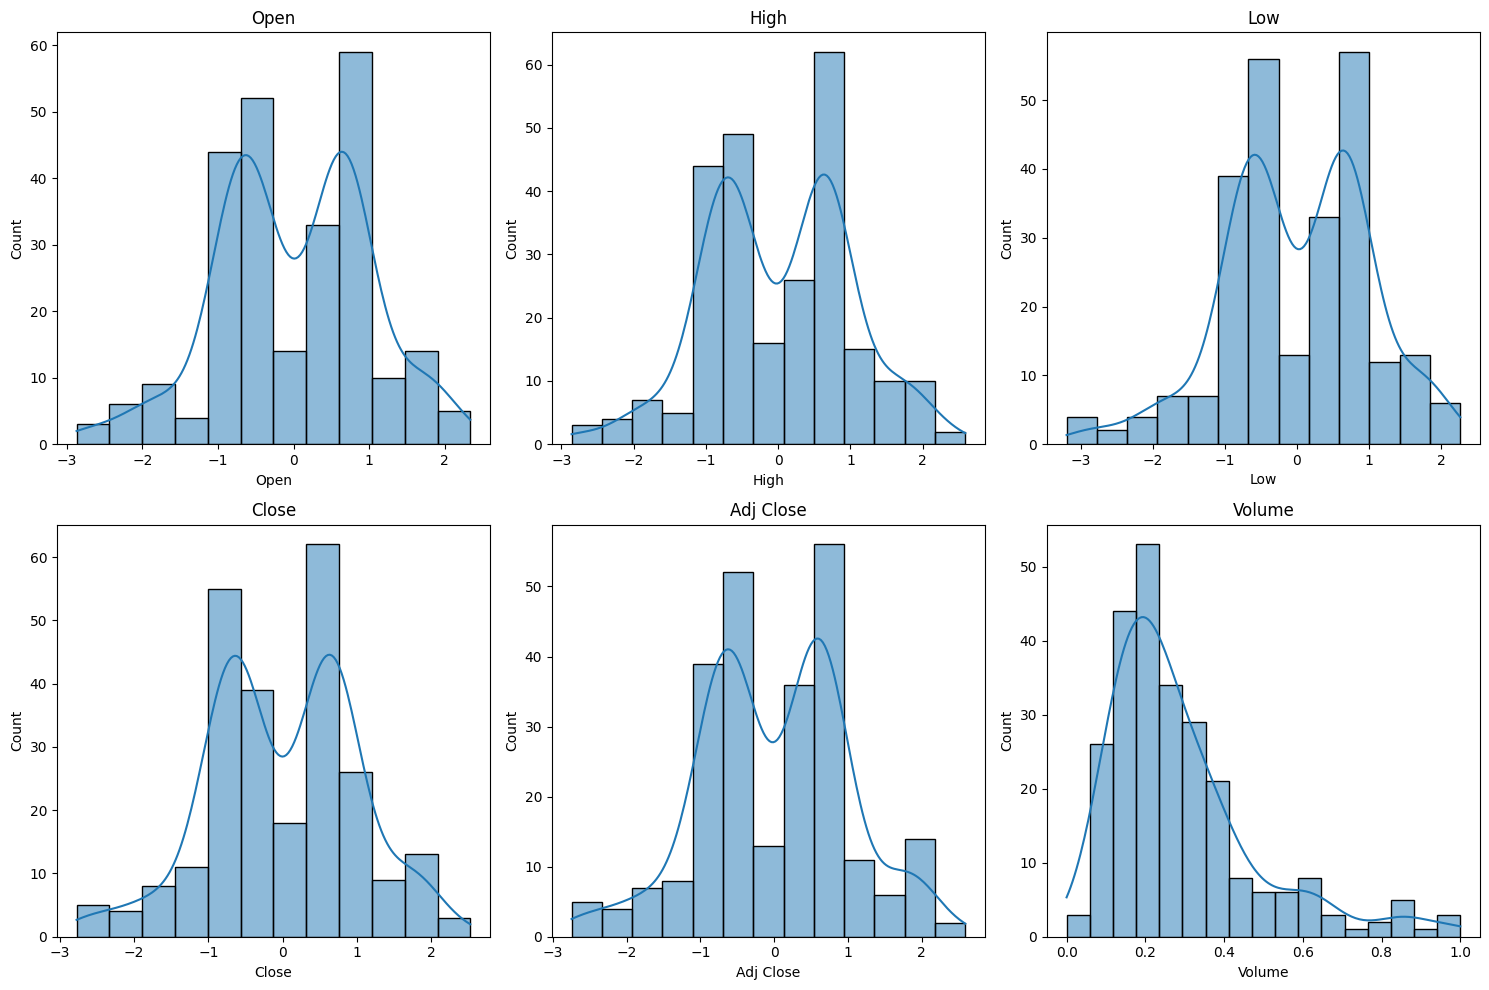

In [15]:
# X, y 병합해서 스케일링 후 plot 그리기
X_scaled_DF = pd.DataFrame(X_scaled, columns=['Open', 'High', 'Low', 'Close', 'Adj Close'])
y_scaled_DF = pd.DataFrame(y_scaled, columns=['Volume'])

data2 = pd.concat([X_scaled_DF, y_scaled_DF], axis=1)

# subplot 틀 구성
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# 변수 이름 가져오기
variables = data2.columns

# 각 변수에 대해서 subplot 그리기
for i, var in enumerate(variables):
    sns.histplot(data2[var], kde=True, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(var)

# subplot 간격 조절
plt.tight_layout()

# 그래프 보여주기
plt.show()

In [16]:
data2.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2.530000e+02,2.530000e+02,2.530000e+02,2.530000e+02,2.530000e+02,253.000000
mean,1.600828e-15,-1.965929e-16,8.987102e-16,6.459479e-16,-4.774398e-16,0.291184
std,1.001982e+00,1.001982e+00,1.001982e+00,1.001982e+00,1.001982e+00,0.190616
min,-2.869422e+00,-2.859601e+00,-3.194029e+00,-2.773793e+00,-2.749020e+00,0.000000
25%,-7.174044e-01,-7.395146e-01,-6.668797e-01,-7.087378e-01,-6.915443e-01,0.161569
50%,6.761427e-02,2.989786e-02,9.095433e-02,4.445086e-02,9.413155e-02,0.237375
75%,7.082249e-01,6.873151e-01,7.090240e-01,7.036256e-01,6.467957e-01,0.354016
max,2.337982e+00,2.589008e+00,2.265068e+00,2.527703e+00,2.594114e+00,1.000000


이제 Train 데이터와 Test 데이터를 분리하자. 이때 시계열 데이터를 다루고 있기 때문에 train_test_split을 사용하지 않고 인덱스 기준으로 200개로 나눈다.

In [17]:
X_train = X_scaled[:200, :]
X_test = X_scaled[200:, :]

y_train = y_scaled[:200, :]
y_test = y_scaled[200:, :]

print('Training Data Shape :', X_train.shape,',', y_train.shape)
print('Test Data Shape :', X_test.shape,',', y_test.shape)

Training Data Shape : (200, 5) , (200, 1)
Test Data Shape : (53, 5) , (53, 1)


여기서 지정한 데이터는 그 자체로 신경망에 보낼 수 없다. 따라서 **신경망에서 정의된 형태 및 크기**에 따라 데이터셋을 조정해야 한다.
- 여기서는 LSTM을 사용하기 때문에 이에 맞춰준다.

In [18]:
X_train_tensor = Variable(torch.Tensor(X_train))
X_test_tensor = Variable(torch.Tensor(X_test))

y_train_tensor = Variable(torch.Tensor(y_train))
y_test_tensor = Variable(torch.Tensor(y_test))

- 먼저 각각의 데이터를 탠서로 만들어줬다.
- 😎텐서를 Variable로 감싸면 자동으로 미분이 가능하다. 즉 backward가 호출될 때마다 기울기를 자동으로 계산할 수 있게 된다.

In [19]:
X_train_tensor_r = torch.reshape(X_train_tensor, (X_train_tensor.shape[0], 1, X_train_tensor.shape[1]))
X_test_tensor_r = torch.reshape(X_test_tensor, (X_test_tensor.shape[0], 1, X_test_tensor.shape[1]))

print('Training Data Shape :', X_train_tensor_r.shape,',', y_train_tensor.shape)
print('Test Data Shape :', X_test_tensor_r.shape,',', y_test_tensor.shape)

Training Data Shape : torch.Size([200, 1, 5]) , torch.Size([200, 1])
Test Data Shape : torch.Size([53, 1, 5]) , torch.Size([53, 1])


- torch의 reshape 메서드를 사용해서 텐서의 형태를 변환해줬다. 
- 이번에 사용할 모델은 순환 모델 중 하나인 LSTM이다. 
- 따라서 X 데이터의 형탸는 (샘플 수, 시퀀스 길이, 피처 수) 형태로 만들어줘야 하기 때문에 reshape를 사용해서 변경했다.

### 4. Model

#### 4-1. LSTM

In [43]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) # LSTM layer
        self.fc1 = nn.Linear(hidden_size, 128) # fully connected layer
        self.fc2 = nn.Linear(128, num_classes) # output layer
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)  # 초기 은닉 상태를 장치로 이동
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)  # 초기 셀 상태를 장치로 이동
        output, (hn, cn) = self.lstm(x, (h0, c0))  # LSTM 계층에 장치로 이동한 초기 은닉 상태와 셀 상태를 전달
        hn = hn.view(-1, self.hidden_size)  # 완전연결층 적용을 위해서 데이터를 1차원으로 조정
        out = self.relu(hn)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
    
        return out

- 모델 설계를 완료했다. 이제 학습을 진행하자.

In [53]:
num_epochs = 1000
learning_rate = 0.0001

input_size = 5 # 입력 데이터의 feature 개수
hidden_size = 2 # 은닉층의 뉴런 개수
num_layers = 1 # LSTM 계층의 개수

num_classes = 1 # 클래스 개수

In [54]:
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensor_r.shape[1]) # 시퀀스 개수는 앞서 설정한 것처럼 1이다.
model.to(device)

LSTM(
  (lstm): LSTM(5, 2, batch_first=True)
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [55]:
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [56]:
# 데이터를 CUDA로 옮김
X_train_tensor_r = X_train_tensor_r.to(device)
y_train_tensor = y_train_tensor.to(device)

이제 학습을 진행한다.

In [57]:
for epoch in range(num_epochs+1):
    outputs = model.forward(X_train_tensor_r)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('Epoch: %d, Loss %1.5f' % (epoch, loss.item()))

Epoch: 0, Loss 0.45470
Epoch: 100, Loss 0.20218
Epoch: 200, Loss 0.08755
Epoch: 300, Loss 0.04666
Epoch: 400, Loss 0.03554
Epoch: 500, Loss 0.03212
Epoch: 600, Loss 0.02936
Epoch: 700, Loss 0.02671
Epoch: 800, Loss 0.02418
Epoch: 900, Loss 0.02208
Epoch: 1000, Loss 0.02044


- GPU를 사용하니 학습 속도가 굉장히 빠르다. 또한 epoch 1000에 가까워서는 MSE가 0.02까지 작아진다.
- Loss 값만 확인해서는 얼마나 잘 예측했는지 확인하기 어렵다. 이번에는 예측값 시각화를 통해서 살펴보자.

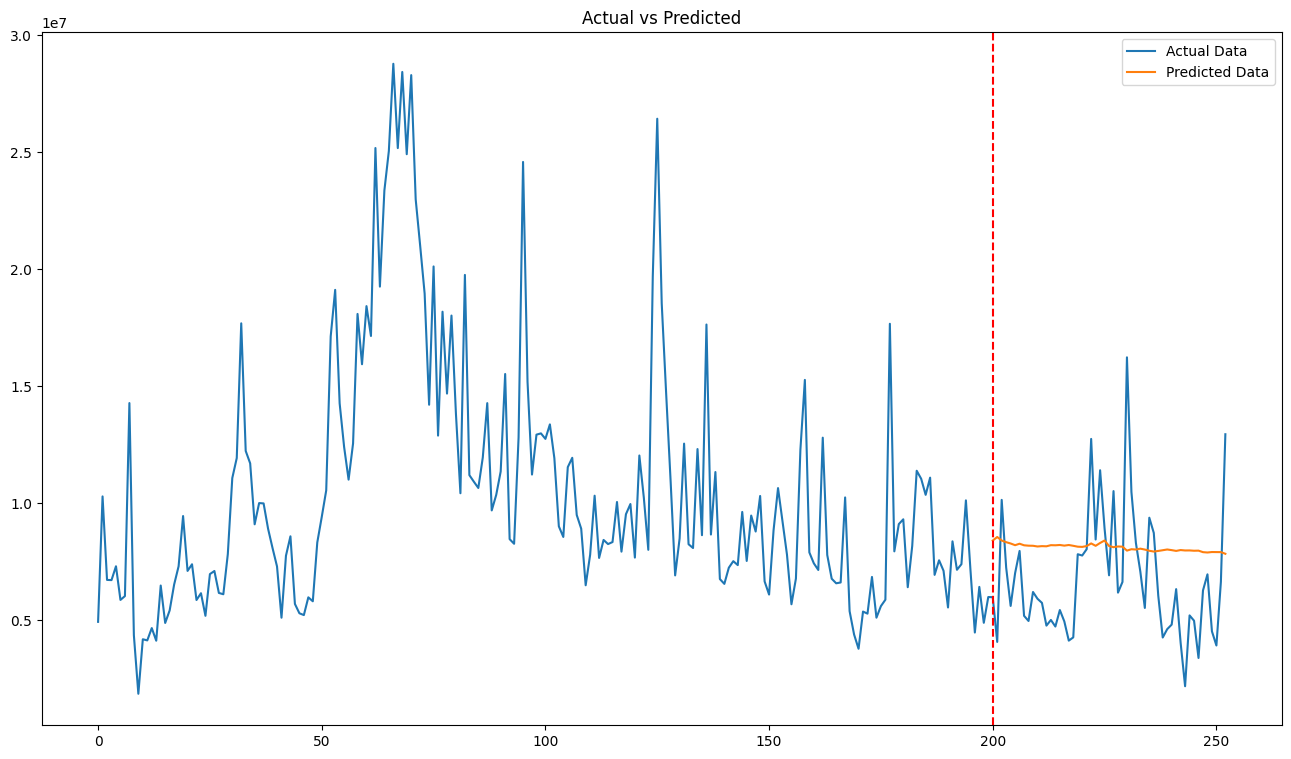

In [58]:
# 예측 수행
with torch.no_grad():
    test_preds = model(X_test_tensor_r.to(device))

# numpy 배열화 및 스케일링 제거
test_preds = test_preds.cpu().numpy() # 이미 cuda에 할당된 데이터라 numpy 적용 불가함. 따라서 cpu() 적용
test_preds = minmax.inverse_transform(test_preds)

# Actual y값 복원
y = data['Volume'].values

# 시각화
plt.figure(figsize=(16, 9))
plt.plot(y, label='Actual Data')
plt.plot(range(200, 200 + len(test_preds)), test_preds, label='Predicted Data')
plt.axvline(x=200, linestyle='--', color='r')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

- Loss 값만 봤을 때는 결과가 괜찮은거 같았는데, 시각화를 해보니깐 딱히 잘 예측하고 있지 않고 있다.

#### 4-2. GRU

이번에는 또 다른 순환 신경망인 GRU를 구현해서 사용해보자.

In [90]:
class GRU(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(GRU, self).__init__()
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length

        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) # GRU layer
        self.fc1 = nn.Linear(hidden_size, 128) # fully connected layer
        self.fc2 = nn.Linear(128, num_classes) # output layer
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # GRU는 셀 상태가 없기 때문에 은닉 상태만 0으로 초기화
        output, (hn) = self.gru(x, (h0))  # LSTM 계층에 장치로 이동한 초기 은닉 상태와 셀 상태를 전달
        hn = hn.view(-1, self.hidden_size)  # 완전연결층 적용을 위해서 데이터를 1차원으로 조정
        out = self.relu(hn)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
    
        return out

In [85]:
num_epochs = 1000
learning_rate = 0.0001

input_size = 5 # 입력 데이터의 feature 개수
hidden_size = 2 # 은닉층의 뉴런 개수
num_layers = 1 # GRU 계층의 개수

num_classes = 1 # 클래스 개수

In [86]:
model2 = GRU(num_classes, input_size, hidden_size, num_layers, X_train_tensor_r.shape[1]) # 시퀀스 개수는 앞서 설정한 것처럼 1이다.
model2.to(device)

GRU(
  (gru): GRU(5, 2, batch_first=True)
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [91]:
# 데이터를 CUDA로 옮김
X_train_tensor_r = X_train_tensor_r.to(device)
y_train_tensor = y_train_tensor.to(device)

In [92]:
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [93]:
for epoch in range(num_epochs+1):
    outputs = model2.forward(X_train_tensor_r)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('Epoch: %d, Loss %1.5f' % (epoch, loss.item()))

Epoch: 0, Loss 0.03840
Epoch: 100, Loss 0.03227
Epoch: 200, Loss 0.03016
Epoch: 300, Loss 0.02872
Epoch: 400, Loss 0.02696
Epoch: 500, Loss 0.02443
Epoch: 600, Loss 0.02056
Epoch: 700, Loss 0.01958
Epoch: 800, Loss 0.01920
Epoch: 900, Loss 0.01896
Epoch: 1000, Loss 0.01880


- 이번에는 MSE 값이 0.18까지 떨어졌다. 동일하게 시각화를 해보자.

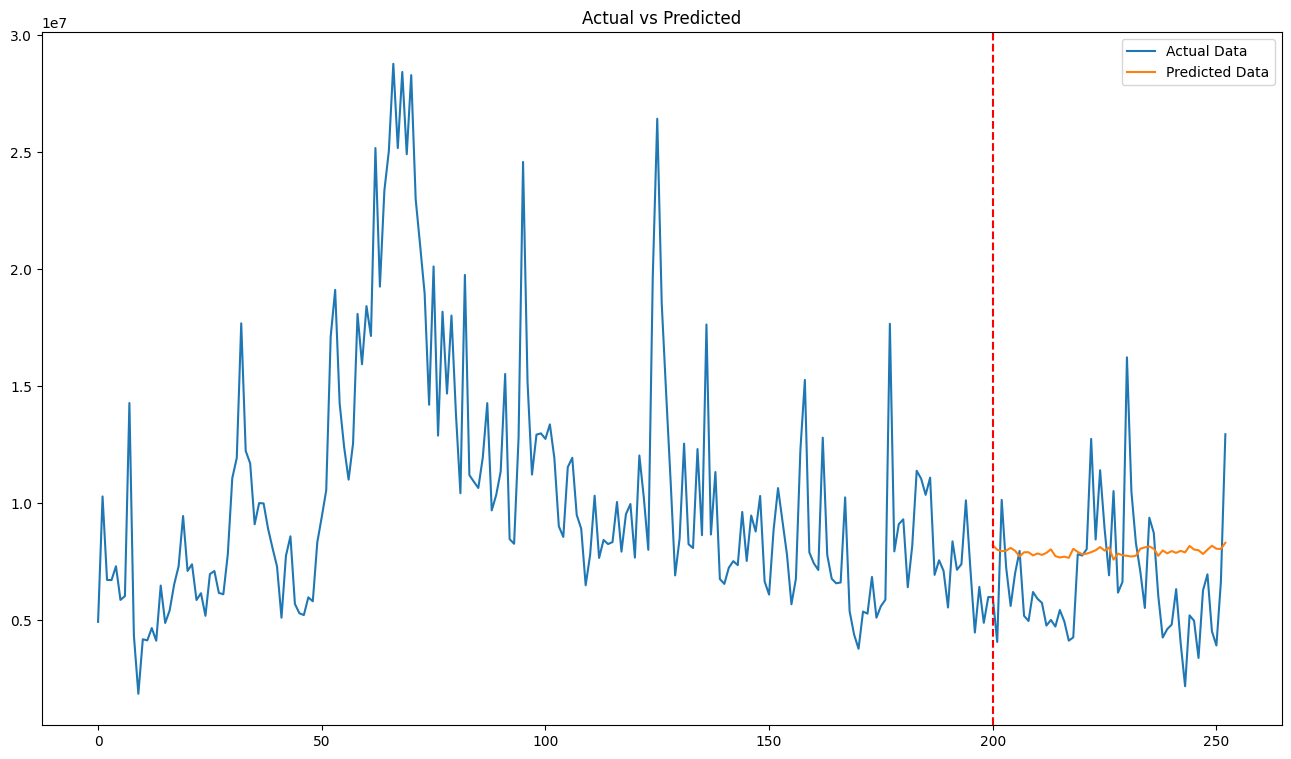

In [94]:
# 예측 수행
with torch.no_grad():
    test_preds = model2(X_test_tensor_r.to(device))

# numpy 배열화 및 스케일링 제거
test_preds = test_preds.cpu().numpy() # 이미 cuda에 할당된 데이터라 numpy 적용 불가함. 따라서 cpu() 적용
test_preds = minmax.inverse_transform(test_preds)

# Actual y값 복원
y = data['Volume'].values

# 시각화
plt.figure(figsize=(16, 9))
plt.plot(y, label='Actual Data')
plt.plot(range(200, 200 + len(test_preds)), test_preds, label='Predicted Data')
plt.axvline(x=200, linestyle='--', color='r')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

- 이전보다 변동에 대해서는 잘 예측하고 있지만, 이것 또한 충분한 변동을 설명하지는 않는 것 같다.

#### 4-3. BiLSTM

이번에는 조금 더 효과적인 양방향 LSTM을 통해서 결과를 살펴보자.

In [101]:
class BiLSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(BiLSTM, self).__init__()
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional = True, batch_first=True) # bidirectional=True로 양방향 LSTM 설정
        self.fc = nn.Linear(hidden_size*2, num_classes) # BiLSTM은 입력데이터가 전방향과 역방향 학습에 모두 전달되기 때문에 두개의 계층이 필요하다.
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)).to(device)
        c0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.relu(out)

        return out

- 양방향 학습이기 때문에 전방향, 역방향을 모두 고려해서 뉴런과 은닉 층을 모두 2배 해준다.

In [102]:
num_epochs = 1000
learning_rate = 0.0001

input_size = 5 # 입력 데이터의 feature 개수
hidden_size = 2 # 은닉층의 뉴런 개수
num_layers = 1 # GRU 계층의 개수

num_classes = 1 # 클래스 개수

model3 = BiLSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensor_r.shape[1]); model3.to(device)

criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate)

In [103]:
for epoch in range(num_epochs+1):
    output = model3.forward(X_train_tensor_r.to(device))
    optimizer.zero_grad()
    loss = criterion(output, y_train_tensor.to(device))
    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
        print('Epoch: %d, Loss %1.5f' % (epoch, loss.item()))

Epoch: 0, Loss 0.11566
Epoch: 100, Loss 0.10173
Epoch: 200, Loss 0.08893
Epoch: 300, Loss 0.07726
Epoch: 400, Loss 0.06682
Epoch: 500, Loss 0.05768
Epoch: 600, Loss 0.04987
Epoch: 700, Loss 0.04337
Epoch: 800, Loss 0.03811
Epoch: 900, Loss 0.03398
Epoch: 1000, Loss 0.03083


- 오차는 오히려 LSTM과 GRU보다 크게 나온다.

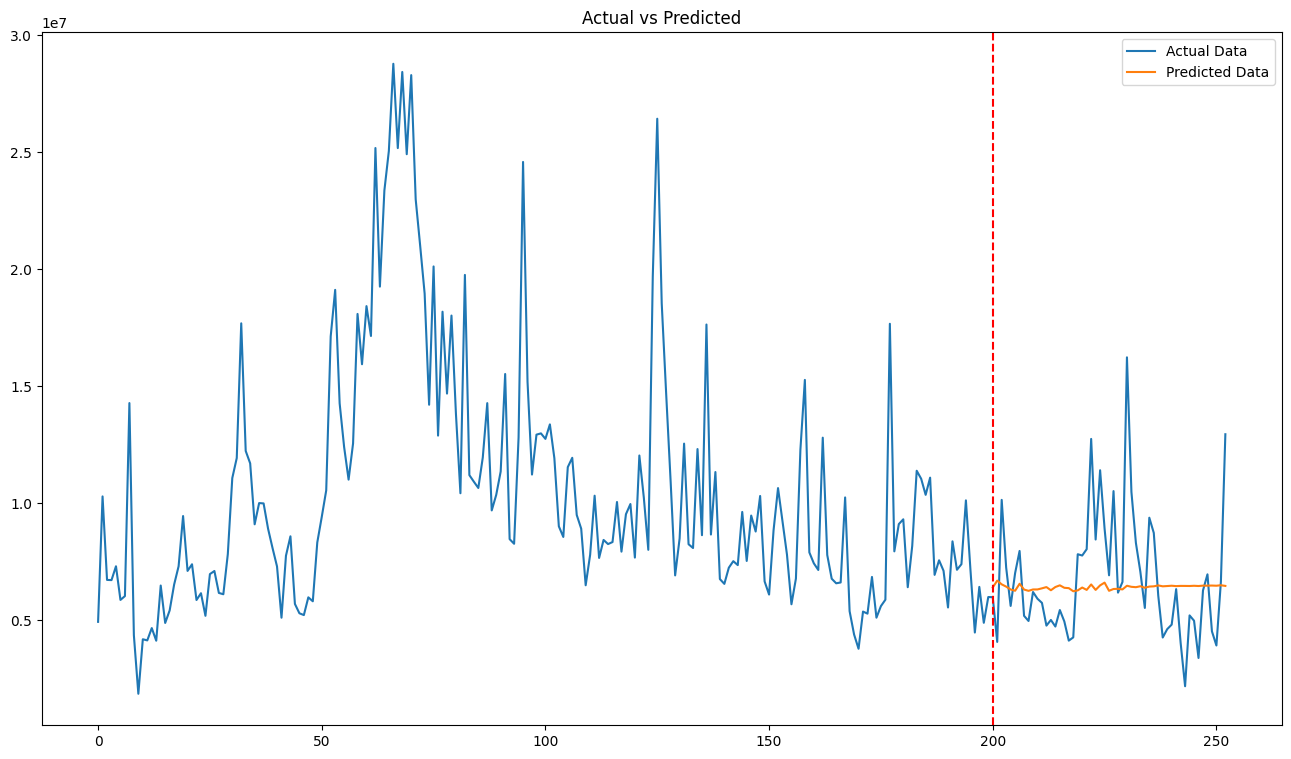

In [104]:
# 예측 수행
with torch.no_grad():
    test_preds = model3(X_test_tensor_r.to(device))

# numpy 배열화 및 스케일링 제거
test_preds = test_preds.cpu().numpy() # 이미 cuda에 할당된 데이터라 numpy 적용 불가함. 따라서 cpu() 적용
test_preds = minmax.inverse_transform(test_preds)

# Actual y값 복원
y = data['Volume'].values

# 시각화
plt.figure(figsize=(16, 9))
plt.plot(y, label='Actual Data')
plt.plot(range(200, 200 + len(test_preds)), test_preds, label='Predicted Data')
plt.axvline(x=200, linestyle='--', color='r')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

- 예측 결과는 이전이랑 비슷하게 별로인 것 같다. 모델 구성이나 학습에서는 문제가 없었는데 다른 부분에서 문제가 있었을 수도 있으니깐 다시 한번 살펴보는 과정도 필요할 것 같다.